In [1]:
from torchvision import datasets
import torch
data_folder = '~/data/FMNIST' # This can be any directory you want
# to download FMNIST to
fmnist = datasets.FashionMNIST(data_folder, download=True, train=True)

100%|██████████| 26421880/26421880 [00:03<00:00, 8446067.86it/s] 


Extracting /root/data/FMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to /root/data/FMNIST/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 67512.05it/s]


Extracting /root/data/FMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /root/data/FMNIST/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 2650709.90it/s]


Extracting /root/data/FMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /root/data/FMNIST/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 6167459.87it/s]

Extracting /root/data/FMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/data/FMNIST/FashionMNIST/raw



In [5]:
tr_images = fmnist.data
tr_targets = fmnist.targets

In [6]:
unique_values = tr_targets.unique()

In [7]:
print(f'tr_images & tr_targets:\n\tX - {tr_images.shape}\n\tY -\
{tr_targets.shape}\n\tY - Unique Values : {unique_values}')
print(f'TASK:\n\t{len(unique_values)} class Classification')
print(f'UNIQUE CLASSES:\n\t{fmnist.classes}')

tr_images & tr_targets:
	X - torch.Size([60000, 28, 28])
	Y -torch.Size([60000])
	Y - Unique Values : tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
TASK:
	10 class Classification
UNIQUE CLASSES:
	['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

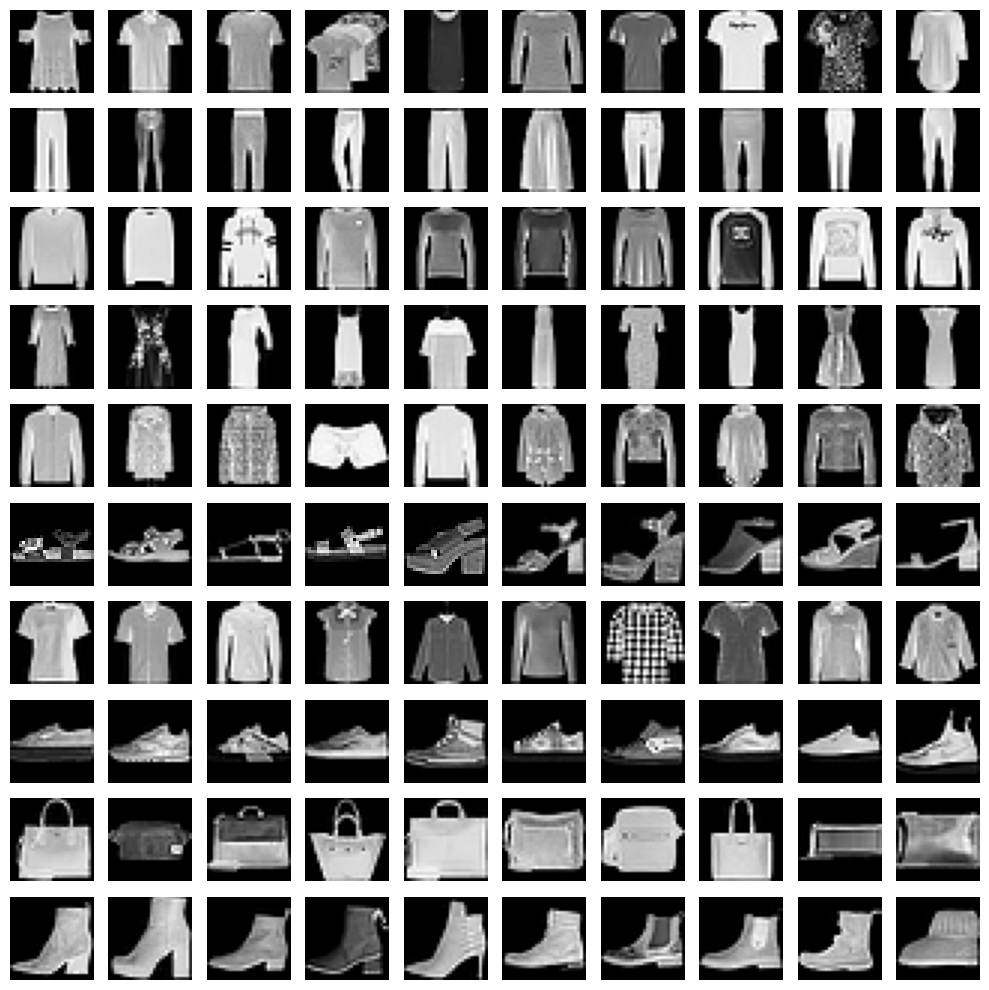

In [10]:
R, C = len(tr_targets.unique()), 10
fig, ax = plt.subplots(R, C, figsize=(10,10))
for label_class, plot_row in enumerate(ax):
  label_x_rows = np.where(tr_targets == label_class)[0]
  for plot_cell in plot_row:
    plot_cell.grid(False); plot_cell.axis('off')
    ix = np.random.choice(label_x_rows)
    x, y = tr_images[ix], tr_targets[ix]
    plot_cell.imshow(x, cmap='gray')
plt.tight_layout()

 **Huấn luyện mạng nơ-ron**


In [11]:
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn

In [13]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
device = "cuda" if torch.cuda.is_available() else "cpu"
from torchvision import datasets
data_folder = '~/data/FMNIST' # This can be any directory you want to
# download FMNIST to
fmnist = datasets.FashionMNIST(data_folder, download=True, train=True)
tr_images = fmnist.data
tr_targets = fmnist.targets

In [14]:
class FMNISTDataset(Dataset):
  def __init__(self, x, y):
    x = x.float()
    x = x.view(-1,28*28)
    self.x, self.y = x, y
  def __getitem__(self, ix):
    x, y = self.x[ix], self.y[ix]
    return x.to(device), y.to(device)
  def __len__(self):
    return len(self.x)

In [15]:
def get_data():
  train = FMNISTDataset(tr_images, tr_targets)
  trn_dl = DataLoader(train, batch_size=32, shuffle=True)
  return trn_dl

In [16]:
from torch.optim import SGD
def get_model():
  model = nn.Sequential(
  nn.Linear(28 * 28, 1000),
  nn.ReLU(),
  nn.Linear(1000, 10)
  ).to(device)
  loss_fn = nn.CrossEntropyLoss()
  optimizer = SGD(model.parameters(), lr=1e-2)
  return model, loss_fn, optimizer

In [17]:
tr_images = fmnist.data
tr_targets = fmnist.targets

In [18]:
def train_batch(x, y, model, opt, loss_fn):
  model.train() # <- let's hold on to this until we reach dropout section
  # call your model like any python function on your batch of inputs
  prediction = model(x)
  # compute loss
  batch_loss = loss_fn(prediction, y)
  # based on the forward pass in `model(x)` compute all the gradients of
  # 'model.parameters()'
  batch_loss.backward()
  # apply new-weights = f(old-weights, old-weight-gradients) where
  # "f" is the optimizer
  optimizer.step()
  # Flush gradients memory for next batch of calculations
  optimizer.zero_grad()
  return batch_loss.item()

In [19]:
# since there's no need for updating weights,
# we might as well not compute the gradients.
# Using this '@' decorator on top of functions
# will disable gradient computation in the entire function
@torch.no_grad()
def accuracy(x, y, model):
  model.eval() # <- let's wait till we get to dropout section
  # get the prediction matrix for a tensor of `x` images
  prediction = model(x)
  # compute if the location of maximum in each row coincides
  # with ground truth
  max_values, argmaxes = prediction.max(-1)
  is_correct = argmaxes == y
  return is_correct.cpu().numpy().tolist()

0
1
2
3
4


<ipython-input-22-0d2373d40a67>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in


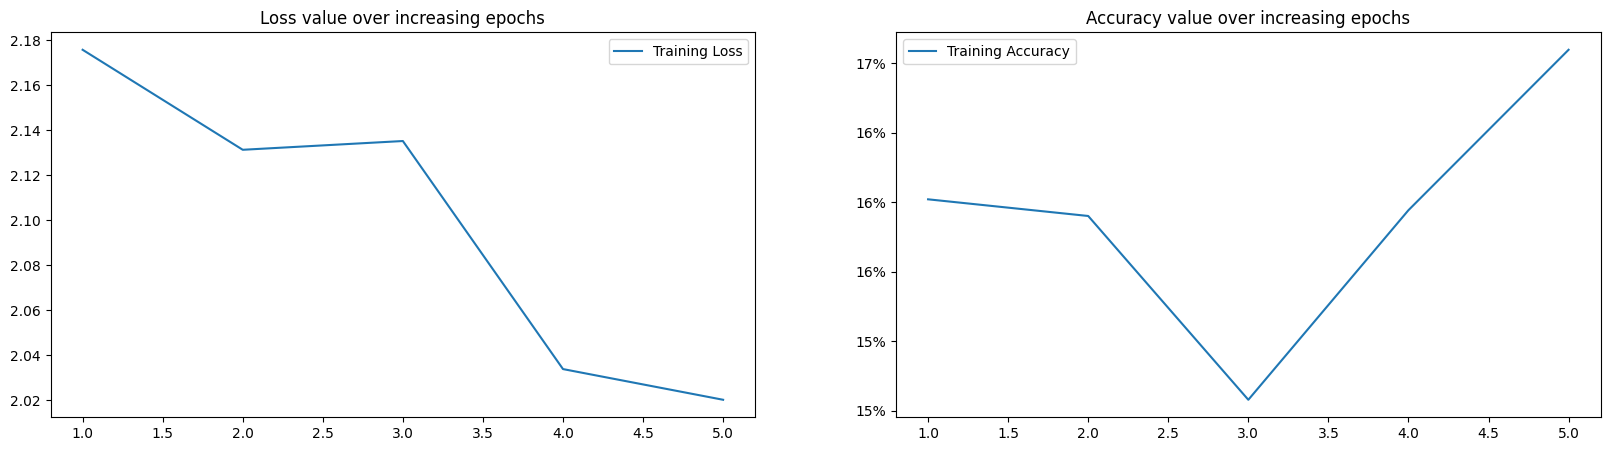

In [22]:
trn_dl = get_data()
model, loss_fn, optimizer = get_model()
losses, accuracies = [], []
for epoch in range(5):
  print(epoch)
  epoch_losses, epoch_accuracies = [], []
  for ix, batch in enumerate(iter(trn_dl)):
    x, y = batch
    batch_loss = train_batch(x, y, model, optimizer, loss_fn)
  epoch_losses.append(batch_loss)
  epoch_loss = np.array(epoch_losses).mean()
  for ix, batch in enumerate(iter(trn_dl)):
    x, y = batch
    is_correct = accuracy(x, y, model)
    epoch_accuracies.extend(is_correct)
  epoch_accuracy = np.mean(epoch_accuracies)
  losses.append(epoch_loss)
  accuracies.append(epoch_accuracy)
epochs = np.arange(5)+1
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.title('Loss value over increasing epochs')
plt.plot(epochs, losses, label='Training Loss')
plt.legend()
plt.subplot(122)
plt.title('Accuracy value over increasing epochs')
plt.plot(epochs, accuracies, label='Training Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in
plt.gca().get_yticks()])
plt.legend()

**Chia tỉ lệ tập dữ liệu để cải thiện độ chính xác của mô hình**

In [23]:
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
device = "cuda" if torch.cuda.is_available() else "cpu"
import numpy as np
data_folder = '~/data/FMNIST' # This can be any directory you want
# to download FMNIST to
fmnist = datasets.FashionMNIST(data_folder, download=True, train=True)
tr_images = fmnist.data
tr_targets = fmnist.targets

In [24]:
class FMNISTDataset(Dataset):
  def __init__(self, x, y):
    x = x.float()/255
    x = x.view(-1,28*28)
    self.x, self.y = x, y
  def __getitem__(self, ix):
    x, y = self.x[ix], self.y[ix]
    return x.to(device), y.to(device)
  def __len__(self):
    return len(self.x)

In [25]:
def get_data():
  train = FMNISTDataset(tr_images, tr_targets)
  trn_dl = DataLoader(train, batch_size=32, shuffle=True)
  return trn_dl
from torch.optim import SGD
def get_model():
  model = nn.Sequential(
  nn.Linear(28 * 28, 1000),
  nn.ReLU(),
  nn.Linear(1000, 10)
  ).to(device)
  loss_fn = nn.CrossEntropyLoss()
  optimizer = SGD(model.parameters(), lr=1e-2)
  return model, loss_fn, optimizer
def train_batch(x, y, model, opt, loss_fn):
  model.train()
  # call your model like any python function on your batch of inputs
  prediction = model(x)
  # compute loss
  batch_loss = loss_fn(prediction, y)
  # based on the forward pass in `model(x)` compute all the gradients of
  # 'model.parameters()'
  batch_loss.backward()
  # apply new-weights = f(old-weights, old-weight-gradients)
  # where "f" is the optimizer
  optimizer.step()
  # Flush memory for next batch of calculations
  optimizer.zero_grad()
  return batch_loss.item()
def accuracy(x, y, model):
  model.eval()
  # since there's no need for updating weights, we might
  # as well not compute the gradients
  with torch.no_grad():
  # get the prediction matrix for a tensor of `x` images
    prediction = model(x)
  # compute if the location of maximum in each row coincides
  # with ground truth
  max_values, argmaxes = prediction.max(-1)
  is_correct = argmaxes == y
  return is_correct.cpu().numpy().tolist()
trn_dl = get_data()
model, loss_fn, optimizer = get_model()


In [26]:
losses, accuracies = [], []
for epoch in range(5):
  print(epoch)
  epoch_losses, epoch_accuracies = [], []
  for ix, batch in enumerate(iter(trn_dl)):
    x, y = batch
    batch_loss = train_batch(x, y, model, optimizer, loss_fn)
    epoch_losses.append(batch_loss)
  epoch_loss = np.array(epoch_losses).mean()
  for ix, batch in enumerate(iter(trn_dl)):
    x, y = batch
    is_correct = accuracy(x, y, model)
    epoch_accuracies.extend(is_correct)
  epoch_accuracy = np.mean(epoch_accuracies)
  losses.append(epoch_loss)
  accuracies.append(epoch_accuracy)

0
1
2
3
4


<ipython-input-27-48201efd1fe1>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in


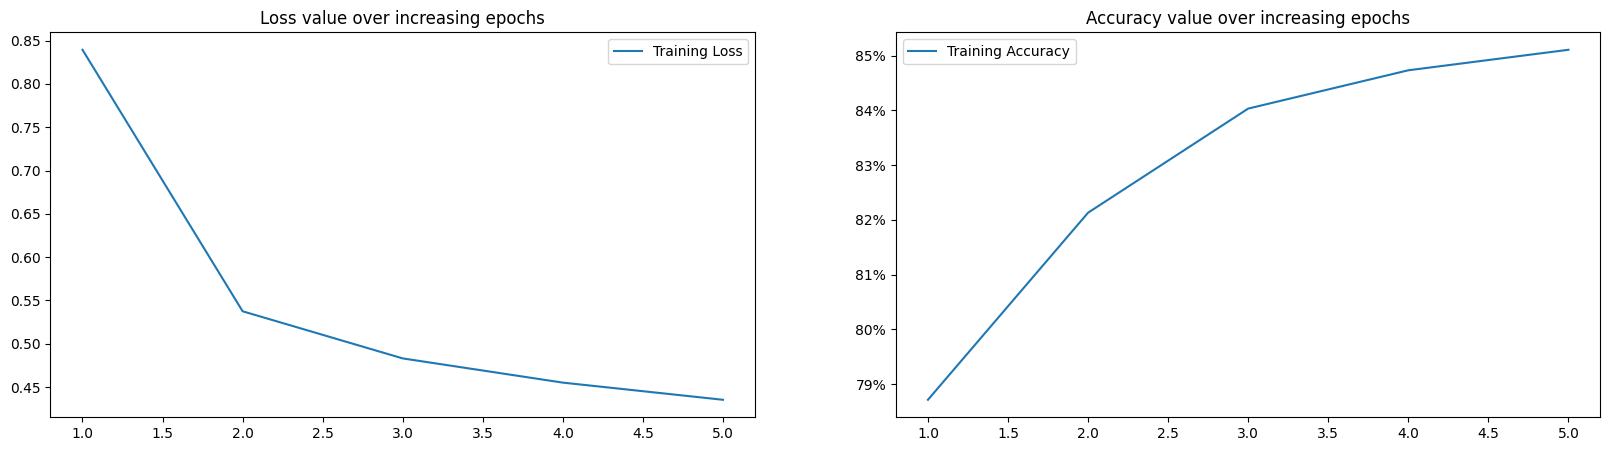

In [27]:
epochs = np.arange(5)+1
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.title('Loss value over increasing epochs')
plt.plot(epochs, losses, label='Training Loss')
plt.legend()
plt.subplot(122)
plt.title('Accuracy value over increasing epochs')
plt.plot(epochs, accuracies, label='Training Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in
plt.gca().get_yticks()])
plt.legend()

# Hiểu được tác động của việc thay đổi kích thước bó

**Kích thước bó 32**

In [28]:
from torchvision import datasets
import torch
data_folder = '~/data/FMNIST' # This can be any directory you want to
# download FMNIST to

<ipython-input-29-805124f35414>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in


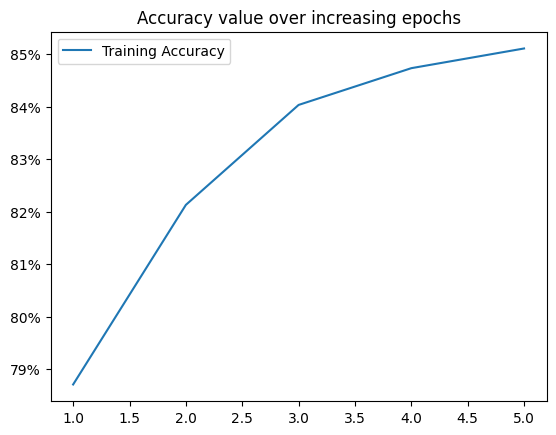

In [29]:
val_fmnist = datasets.FashionMNIST(data_folder, download=True, train=False)
val_images = val_fmnist.data
val_targets = val_fmnist.targets
plt.title('Accuracy value over increasing epochs')
plt.plot(epochs, accuracies, label='Training Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in
plt.gca().get_yticks()])
plt.legend()

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [34]:
class FMNISTDataset(Dataset):
  def __init__(self, x, y):
    x = x.float()/255
    x = x.view(-1,28*28)
    self.x, self.y = x, y
  def __getitem__(self, ix):
    x, y = self.x[ix], self.y[ix]
    return x.to(device), y.to(device)
  def __len__(self):
    return len(self.x)

from torch.optim import SGD
from torch.optim import Adam

def get_model():
  model = nn.Sequential(
  nn.Linear(28 * 28, 1000),
  nn.ReLU(),
  nn.Linear(1000, 10)
  ).to(device)
  loss_fn = nn.CrossEntropyLoss()
  optimizer = Adam(model.parameters(), lr=1e-2)
  return model, loss_fn, optimizer
def train_batch(x, y, model, opt, loss_fn):
  model.train()
  prediction = model(x)
  batch_loss = loss_fn(prediction, y)
  batch_loss.backward()
  optimizer.step()
  optimizer.zero_grad()
  return batch_loss.item()
  def accuracy(x, y, model):
    model.eval()
# this is the same as @torch.no_grad
# at the top of function, only difference
# being, grad is not computed in the with scope
    with torch.no_grad():
      prediction = model(x)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

In [35]:
def get_data():
  train = FMNISTDataset(tr_images, tr_targets)
  trn_dl = DataLoader(train, batch_size=32, shuffle=True)
  val = FMNISTDataset(val_images, val_targets)
  val_dl = DataLoader(val, batch_size=len(val_images), shuffle=False)
  return trn_dl, val_dl

In [36]:
@torch.no_grad()
def val_loss(x, y, model):
  prediction = model(x)
  val_loss = loss_fn(prediction, y)
  return val_loss.item()

In [37]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

In [38]:
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(5):
  print(epoch)
  train_epoch_losses, train_epoch_accuracies = [], []
  for ix, batch in enumerate(iter(trn_dl)):
    x, y = batch
    batch_loss = train_batch(x, y, model, optimizer, loss_fn)
    train_epoch_losses.append(batch_loss)
  train_epoch_loss = np.array(train_epoch_losses).mean()
  for ix, batch in enumerate(iter(trn_dl)):
    x, y = batch
    is_correct = accuracy(x, y, model)
    train_epoch_accuracies.extend(is_correct)
  train_epoch_accuracy = np.mean(train_epoch_accuracies)
  for ix, batch in enumerate(iter(val_dl)):
    x, y = batch
    val_is_correct = accuracy(x, y, model)
    validation_loss = val_loss(x, y, model)
  val_epoch_accuracy = np.mean(val_is_correct)
  train_losses.append(train_epoch_loss)
  train_accuracies.append(train_epoch_accuracy)
  val_losses.append(validation_loss)
  val_accuracies.append(val_epoch_accuracy)

0
1
2
3
4


In [39]:
epochs = np.arange(5)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

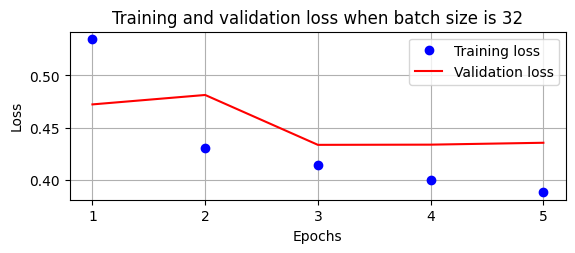

<ipython-input-40-522e9d98fa8d>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in


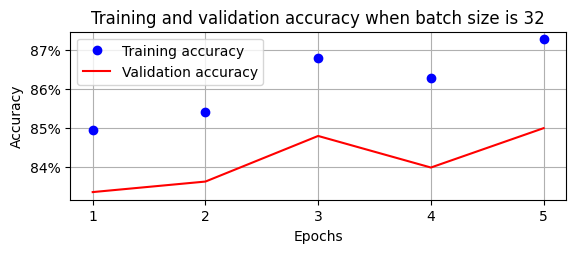

In [40]:
%matplotlib inline
plt.subplot(211)
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation loss when batch size is 32')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy when batch size is 32')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in
plt.gca().get_yticks()])
plt.legend()
plt.grid('off')
plt.show()

**Kích thước bó 10.000:**

0
1
2
3
4


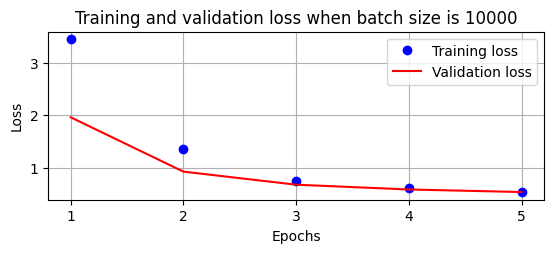

<ipython-input-41-2bc5a8ecc4ff>:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in


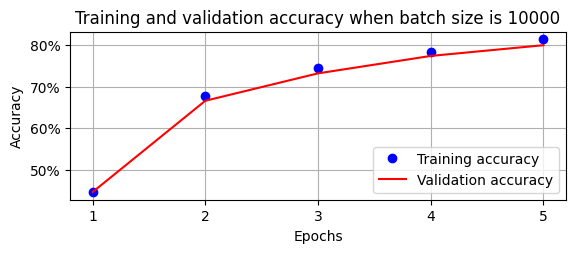

In [41]:
def get_data():
  train = FMNISTDataset(tr_images, tr_targets)
  trn_dl = DataLoader(train, batch_size=10000, shuffle=True)
  val = FMNISTDataset(val_images, val_targets)
  val_dl = DataLoader(val, batch_size=len(val_images), shuffle=False)
  return trn_dl, val_dl
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(5):
  print(epoch)
  train_epoch_losses, train_epoch_accuracies = [], []
  for ix, batch in enumerate(iter(trn_dl)):
    x, y = batch
    batch_loss = train_batch(x, y, model, optimizer, loss_fn)
    train_epoch_losses.append(batch_loss)
  train_epoch_loss = np.array(train_epoch_losses).mean()
  for ix, batch in enumerate(iter(trn_dl)):
    x, y = batch
    is_correct = accuracy(x, y, model)
    train_epoch_accuracies.extend(is_correct)
  train_epoch_accuracy = np.mean(train_epoch_accuracies)
  for ix, batch in enumerate(iter(val_dl)):
    x, y = batch
    val_is_correct = accuracy(x, y, model)
    validation_loss = val_loss(x, y, model)
  val_epoch_accuracy = np.mean(val_is_correct)
  train_losses.append(train_epoch_loss)
  train_accuracies.append(train_epoch_accuracy)
  val_losses.append(validation_loss)
  val_accuracies.append(val_epoch_accuracy)
epochs = np.arange(5)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.subplot(211)
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation loss when batch size is 10000')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy when batch size is 10000')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in
plt.gca().get_yticks()])
plt.legend()
plt.grid('off')
plt.show()

**Hiểu được tác động của việc thay đổi trình tối ưu hóa sai số.**

Thực hiện những thay đổi này có nghĩa là chỉ một bước trong kích thước bó là 32 sẽ thay đổi

0
1
2
3
4
5
6
7
8
9


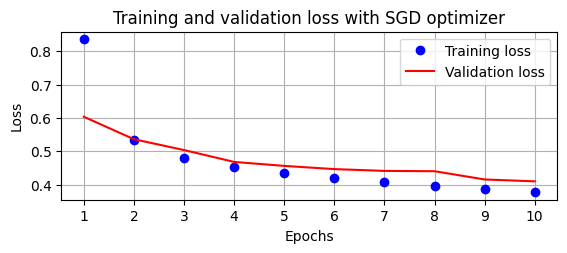

<ipython-input-42-265bb6f6edfd>:120: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in


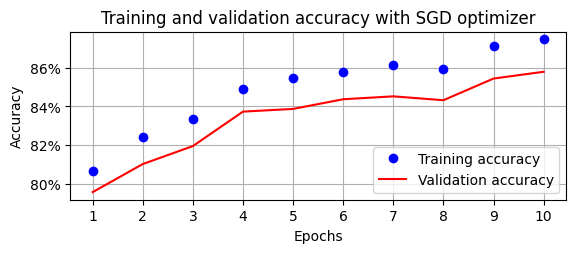

In [42]:
from torchvision import datasets
import torch
data_folder = '~/data/FMNIST' # This can be any directory you want to
# download FMNIST to
fmnist = datasets.FashionMNIST(data_folder, download=True, train=True)
tr_images = fmnist.data
tr_targets = fmnist.targets
val_fmnist = datasets.FashionMNIST(data_folder, download=True, train=False)
val_images = val_fmnist.data
val_targets = val_fmnist.targets
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# SGD optimizer
class FMNISTDataset(Dataset):
  def __init__(self, x, y):
    x = x.float()/255
    x = x.view(-1,28*28)
    self.x, self.y = x, y
  def __getitem__(self, ix):
    x, y = self.x[ix], self.y[ix]
    return x.to(device), y.to(device)
  def __len__(self):
    return len(self.x)

from torch.optim import SGD, Adam
def get_model():
  model = nn.Sequential(
  nn.Linear(28 * 28, 1000),
  nn.ReLU(),
  nn.Linear(1000, 10)
  ).to(device)
  loss_fn = nn.CrossEntropyLoss()
  optimizer = SGD(model.parameters(), lr=1e-2)
  return model, loss_fn, optimizer
def train_batch(x, y, model, opt, loss_fn):
  model.train()
  prediction = model(x)
  batch_loss = loss_fn(prediction, y)
  batch_loss.backward()
  optimizer.step()
  optimizer.zero_grad()
  return batch_loss.item()
def accuracy(x, y, model):
  model.eval()
  # this is the same as @torch.no_grad
  # at the top of function, only difference
  # being, grad is not computed in the with scope
  with torch.no_grad():
    prediction = model(x)
  max_values, argmaxes = prediction.max(-1)
  is_correct = argmaxes == y
  return is_correct.cpu().numpy().tolist()

def get_data():
  train = FMNISTDataset(tr_images, tr_targets)
  trn_dl = DataLoader(train, batch_size=32, shuffle=True)
  val = FMNISTDataset(val_images, val_targets)
  val_dl = DataLoader(val, batch_size=len(val_images), shuffle=False)
  return trn_dl, val_dl

@torch.no_grad()
def val_loss(x, y, model):
  prediction = model(x)
  val_loss = loss_fn(prediction, y)
  return val_loss.item()
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(10):
  print(epoch)
  train_epoch_losses, train_epoch_accuracies = [], []
  for ix, batch in enumerate(iter(trn_dl)):
    x, y = batch
    batch_loss = train_batch(x, y, model, optimizer, loss_fn)
    train_epoch_losses.append(batch_loss)
  train_epoch_loss = np.array(train_epoch_losses).mean()
  for ix, batch in enumerate(iter(trn_dl)):
    x, y = batch
    is_correct = accuracy(x, y, model)
    train_epoch_accuracies.extend(is_correct)
  train_epoch_accuracy = np.mean(train_epoch_accuracies)
  for ix, batch in enumerate(iter(val_dl)):
    x, y = batch
    val_is_correct = accuracy(x, y, model)
    validation_loss = val_loss(x, y, model)
  val_epoch_accuracy = np.mean(val_is_correct)
  train_losses.append(train_epoch_loss)
  train_accuracies.append(train_epoch_accuracy)
  val_losses.append(validation_loss)
  val_accuracies.append(val_epoch_accuracy)
epochs = np.arange(10)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.subplot(211)
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))

plt.title('Training and validation loss with SGD optimizer')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy with SGD optimizer')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in
plt.gca().get_yticks()])
plt.legend()
plt.grid('off')
plt.show()

Adam optimizer

0
1
2
3
4
5
6
7
8
9


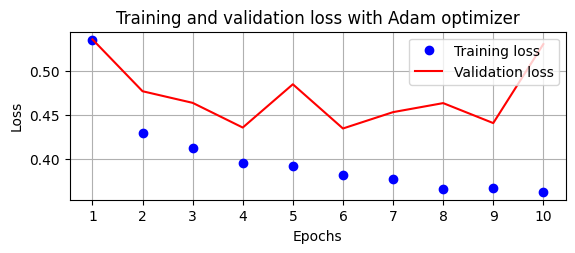

<ipython-input-43-4c66c9e1308c>:62: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in


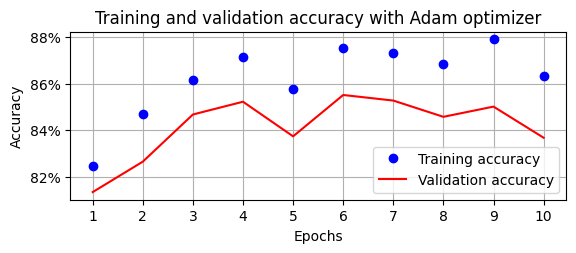

In [43]:
from torch.optim import SGD, Adam
def get_model():
  model = nn.Sequential(
  nn.Linear(28 * 28, 1000),
  nn.ReLU(),
  nn.Linear(1000, 10)
  ).to(device)
  loss_fn = nn.CrossEntropyLoss()
  optimizer = Adam(model.parameters(), lr=1e-2)
  return model, loss_fn, optimizer
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

for epoch in range(10):
  print(epoch)
  train_epoch_losses, train_epoch_accuracies = [], []
  for ix, batch in enumerate(iter(trn_dl)):
    x, y = batch
    batch_loss = train_batch(x, y, model, optimizer, loss_fn)
    train_epoch_losses.append(batch_loss)
  train_epoch_loss = np.array(train_epoch_losses).mean()
  for ix, batch in enumerate(iter(trn_dl)):
    x, y = batch
    is_correct = accuracy(x, y, model)
    train_epoch_accuracies.extend(is_correct)
  train_epoch_accuracy = np.mean(train_epoch_accuracies)
  for ix, batch in enumerate(iter(val_dl)):
    x, y = batch
    val_is_correct = accuracy(x, y, model)
    validation_loss = val_loss(x, y, model)
  val_epoch_accuracy = np.mean(val_is_correct)
  train_losses.append(train_epoch_loss)
  train_accuracies.append(train_epoch_accuracy)
  val_losses.append(validation_loss)
  val_accuracies.append(val_epoch_accuracy)

epochs = np.arange(10)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.subplot(211)
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation loss with Adam optimizer')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy with Adam optimizer')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in
plt.gca().get_yticks()])
plt.legend()
plt.grid('off')
plt.show()

**Hiểu tác động của việc thay đổi tốc độ học**

Tốc độ học cao

0
1
2
3
4


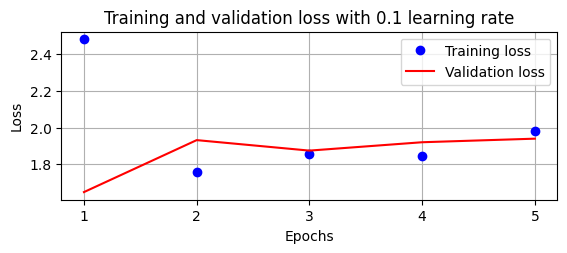

<ipython-input-3-328ef8c2fdd7>:122: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in


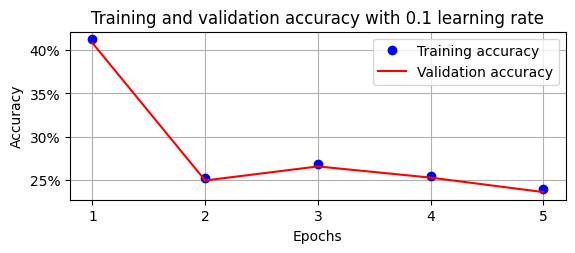

In [3]:
from torchvision import datasets
import torch
data_folder = '~/data/FMNIST' # This can be any directory you want to
# download FMNIST to
fmnist = datasets.FashionMNIST(data_folder, download=True, train=True)
tr_images = fmnist.data
tr_targets = fmnist.targets
val_fmnist = datasets.FashionMNIST(data_folder, download=True, train=False)
val_images = val_fmnist.data
val_targets = val_fmnist.targets
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# High Learning Rate
class FMNISTDataset(Dataset):
  def __init__(self, x, y):
    x = x.float()/255
    x = x.view(-1,28*28)
    self.x, self.y = x, y
  def __getitem__(self, ix):
    x, y = self.x[ix], self.y[ix]
    return x.to(device), y.to(device)
  def __len__(self):
    return len(self.x)

from torch.optim import SGD, Adam
def get_model():
  model = nn.Sequential(
  nn.Linear(28 * 28, 1000),
  nn.ReLU(),
  nn.Linear(1000, 10)
  ).to(device)
  loss_fn = nn.CrossEntropyLoss()
  optimizer = Adam(model.parameters(), lr=1e-1)
  return model, loss_fn, optimizer
def train_batch(x, y, model, opt, loss_fn):
  model.train()
  prediction = model(x)
  batch_loss = loss_fn(prediction, y)
  batch_loss.backward()
  optimizer.step()
  optimizer.zero_grad()
  return batch_loss.item()
def accuracy(x, y, model):
  model.eval()
  # this is the same as @torch.no_grad
  # at the top of function, only difference
  # being, grad is not computed in the with scope
  with torch.no_grad():
    prediction = model(x)
  max_values, argmaxes = prediction.max(-1)
  is_correct = argmaxes == y
  return is_correct.cpu().numpy().tolist()
def get_data():
  train = FMNISTDataset(tr_images, tr_targets)
  trn_dl = DataLoader(train, batch_size=32, shuffle=True)
  val = FMNISTDataset(val_images, val_targets)
  val_dl = DataLoader(val, batch_size=len(val_images), shuffle=False)
  return trn_dl, val_dl

@torch.no_grad()
def val_loss(x, y, model):
  prediction = model(x)
  val_loss = loss_fn(prediction, y)
  return val_loss.item()

trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(5):
  print(epoch)
  train_epoch_losses, train_epoch_accuracies = [], []
  for ix, batch in enumerate(iter(trn_dl)):
    x, y = batch
    batch_loss = train_batch(x, y, model, optimizer, loss_fn)
    train_epoch_losses.append(batch_loss)
  train_epoch_loss = np.array(train_epoch_losses).mean()
  for ix, batch in enumerate(iter(trn_dl)):
    x, y = batch
    is_correct = accuracy(x, y, model)
    train_epoch_accuracies.extend(is_correct)
  train_epoch_accuracy = np.mean(train_epoch_accuracies)
  for ix, batch in enumerate(iter(val_dl)):
    x, y = batch
    val_is_correct = accuracy(x, y, model)
    validation_loss = val_loss(x, y, model)
  val_epoch_accuracy = np.mean(val_is_correct)
  train_losses.append(train_epoch_loss)
  train_accuracies.append(train_epoch_accuracy)
  val_losses.append(validation_loss)
  val_accuracies.append(val_epoch_accuracy)

epochs = np.arange(5)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.subplot(211)
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation loss with 0.1 learning rate')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy with 0.1 learning rate')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in
plt.gca().get_yticks()])
plt.legend()
plt.grid('off')
plt.show()

Tốc độ học trung bình

0
1
2
3
4


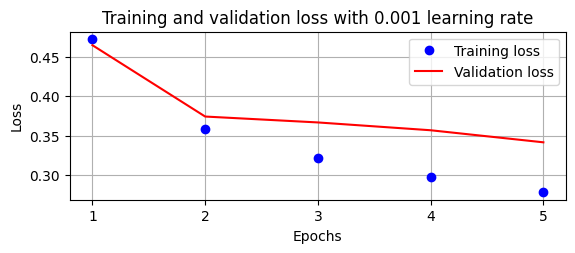

<ipython-input-4-0614db65bee5>:61: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in


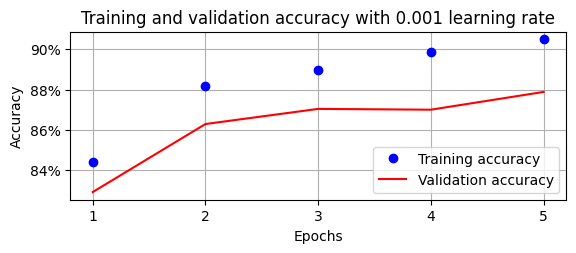

In [4]:
def get_model():
  model = nn.Sequential(
  nn.Linear(28 * 28, 1000),
  nn.ReLU(),
  nn.Linear(1000, 10)
  ).to(device)
  loss_fn = nn.CrossEntropyLoss()
  optimizer = Adam(model.parameters(), lr=1e-3)
  return model, loss_fn, optimizer
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

for epoch in range(5):
  print(epoch)
  train_epoch_losses, train_epoch_accuracies = [], []
  for ix, batch in enumerate(iter(trn_dl)):
    x, y = batch
    batch_loss = train_batch(x, y, model, optimizer, loss_fn)
    train_epoch_losses.append(batch_loss)
  train_epoch_loss = np.array(train_epoch_losses).mean()
  for ix, batch in enumerate(iter(trn_dl)):
    x, y = batch
    is_correct = accuracy(x, y, model)
    train_epoch_accuracies.extend(is_correct)
  train_epoch_accuracy = np.mean(train_epoch_accuracies)
  for ix, batch in enumerate(iter(val_dl)):
    x, y = batch
    val_is_correct = accuracy(x, y, model)
    validation_loss = val_loss(x, y, model)
  val_epoch_accuracy = np.mean(val_is_correct)
  train_losses.append(train_epoch_loss)
  train_accuracies.append(train_epoch_accuracy)
  val_losses.append(validation_loss)
  val_accuracies.append(val_epoch_accuracy)

epochs = np.arange(5)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.subplot(211)
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation loss with 0.001 learning rate')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy with 0.001 learning rate')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in
plt.gca().get_yticks()])
plt.legend()
plt.grid('off')
plt.show()

Tốc độ học thấp

0
1
2
3
4


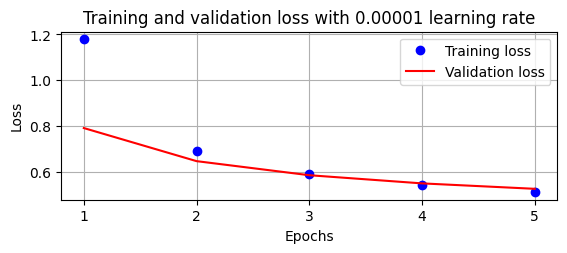

<ipython-input-5-15148abd677e>:60: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in


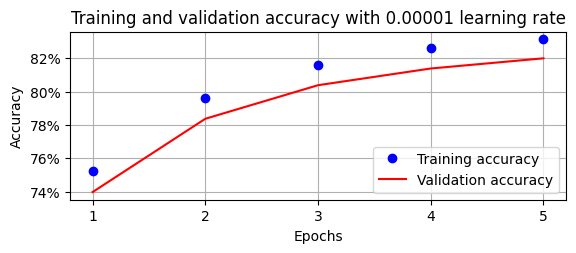

In [5]:
def get_model():
  model = nn.Sequential(
  nn.Linear(28 * 28, 1000),
  nn.ReLU(),
  nn.Linear(1000, 10)
  ).to(device)
  loss_fn = nn.CrossEntropyLoss()
  optimizer = Adam(model.parameters(), lr=1e-5)
  return model, loss_fn, optimizer
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(5):
  print(epoch)
  train_epoch_losses, train_epoch_accuracies = [], []
  for ix, batch in enumerate(iter(trn_dl)):
    x, y = batch
    batch_loss = train_batch(x, y, model, optimizer, loss_fn)
    train_epoch_losses.append(batch_loss)
  train_epoch_loss = np.array(train_epoch_losses).mean()
  for ix, batch in enumerate(iter(trn_dl)):
    x, y = batch
    is_correct = accuracy(x, y, model)
    train_epoch_accuracies.extend(is_correct)
  train_epoch_accuracy = np.mean(train_epoch_accuracies)
  for ix, batch in enumerate(iter(val_dl)):
    x, y = batch
    val_is_correct = accuracy(x, y, model)
    validation_loss = val_loss(x, y, model)
  val_epoch_accuracy = np.mean(val_is_correct)
  train_losses.append(train_epoch_loss)
  train_accuracies.append(train_epoch_accuracy)
  val_losses.append(validation_loss)
  val_accuracies.append(val_epoch_accuracy)

epochs = np.arange(5)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.subplot(211)
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation loss with 0.00001 learning rate')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy with 0.00001 learning rate')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in
plt.gca().get_yticks()])
plt.legend()
plt.grid('off')
plt.show()

**Tác động của việc thay đổi tốc độ học trên tập dữ liệu không được chia tỷ lệ**

Tốc độ học cao

0
1
2
3
4


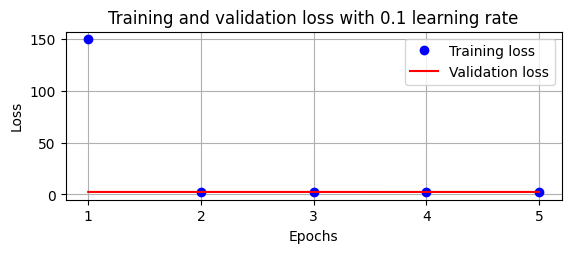

<ipython-input-7-c1e20f522118>:117: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in


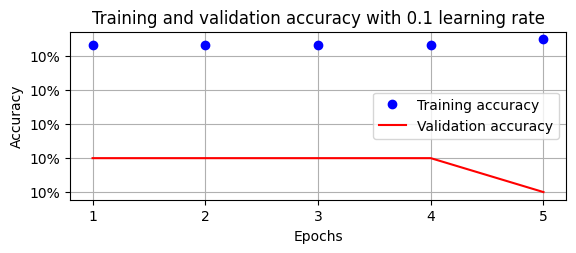

In [7]:
from torchvision import datasets
import torch
data_folder = '~/data/FMNIST' # This can be any directory you want to
# download FMNIST to
fmnist = datasets.FashionMNIST(data_folder, download=True, train=True)
tr_images = fmnist.data
tr_targets = fmnist.targets
val_fmnist = datasets.FashionMNIST(data_folder, download=True, train=False)
val_images = val_fmnist.data
val_targets = val_fmnist.targets
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'
#Hingh Learning Rate
class FMNISTDataset(Dataset):
  def __init__(self, x, y):
    x = x.float()
    x = x.view(-1,28*28)
    self.x, self.y = x, y
  def __getitem__(self, ix):
    x, y = self.x[ix], self.y[ix]
    return x.to(device), y.to(device)
  def __len__(self):
    return len(self.x)
from torch.optim import SGD, Adam
def get_model():
  model = nn.Sequential(
  nn.Linear(28 * 28, 1000),
  nn.ReLU(),
  nn.Linear(1000, 10)
  ).to(device)
  loss_fn = nn.CrossEntropyLoss()
  optimizer = Adam(model.parameters(), lr=1e-1)
  return model, loss_fn, optimizer
def train_batch(x, y, model, opt, loss_fn):
  model.train()
  prediction = model(x)
  batch_loss = loss_fn(prediction, y)
  batch_loss.backward()
  optimizer.step()
  optimizer.zero_grad()
  return batch_loss.item()
def accuracy(x, y, model):
  model.eval()
  # this is the same as @torch.no_grad
  # at the top of function, only difference
  # being, grad is not computed in the with scope
  with torch.no_grad():
    prediction = model(x)
  max_values, argmaxes = prediction.max(-1)
  is_correct = argmaxes == y
  return is_correct.cpu().numpy().tolist()
def get_data():
  train = FMNISTDataset(tr_images, tr_targets)
  trn_dl = DataLoader(train, batch_size=32, shuffle=True)
  val = FMNISTDataset(val_images, val_targets)
  val_dl = DataLoader(val, batch_size=len(val_images), shuffle=False)
  return trn_dl, val_dl

@torch.no_grad()
def val_loss(x, y, model):
  prediction = model(x)
  val_loss = loss_fn(prediction, y)
  return val_loss.item()
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(5):
  print(epoch)
  train_epoch_losses, train_epoch_accuracies = [], []
  for ix, batch in enumerate(iter(trn_dl)):
    x, y = batch
    batch_loss = train_batch(x, y, model, optimizer, loss_fn)
    train_epoch_losses.append(batch_loss)
  train_epoch_loss = np.array(train_epoch_losses).mean()
  for ix, batch in enumerate(iter(trn_dl)):
    x, y = batch
    is_correct = accuracy(x, y, model)
    train_epoch_accuracies.extend(is_correct)
  train_epoch_accuracy = np.mean(train_epoch_accuracies)
  for ix, batch in enumerate(iter(val_dl)):
    x, y = batch
    val_is_correct = accuracy(x, y, model)
    validation_loss = val_loss(x, y, model)
  val_epoch_accuracy = np.mean(val_is_correct)
  train_losses.append(train_epoch_loss)
  train_accuracies.append(train_epoch_accuracy)
  val_losses.append(validation_loss)
  val_accuracies.append(val_epoch_accuracy)
epochs = np.arange(5)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.subplot(211)
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation loss with 0.1 learning rate')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy with 0.1 learning rate')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in
plt.gca().get_yticks()])
plt.legend()
plt.grid('off')
plt.show()

Tốc độ học trung bình

0
1
2
3
4


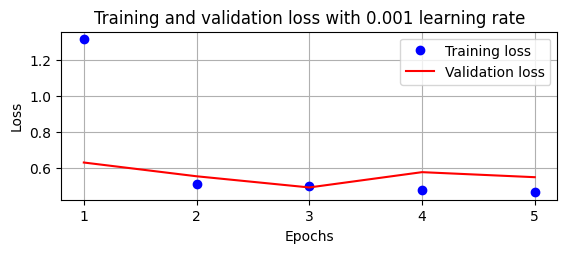

<ipython-input-8-eb1ea924359c>:58: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in


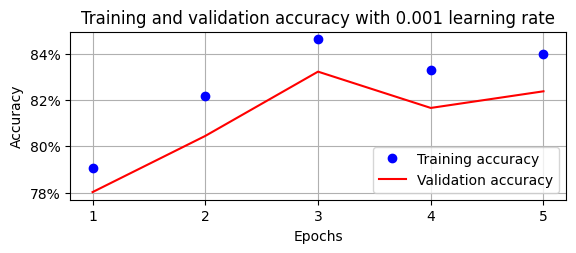

In [8]:
def get_model():
  model = nn.Sequential(
  nn.Linear(28 * 28, 1000),
  nn.ReLU(),
  nn.Linear(1000, 10)
  ).to(device)
  loss_fn = nn.CrossEntropyLoss()
  optimizer = Adam(model.parameters(), lr=1e-3)
  return model, loss_fn, optimizer
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(5):
  print(epoch)
  train_epoch_losses, train_epoch_accuracies = [], []
  for ix, batch in enumerate(iter(trn_dl)):
    x, y = batch
    batch_loss = train_batch(x, y, model, optimizer, loss_fn)
    train_epoch_losses.append(batch_loss)
  train_epoch_loss = np.array(train_epoch_losses).mean()
  for ix, batch in enumerate(iter(trn_dl)):
    x, y = batch
    is_correct = accuracy(x, y, model)
    train_epoch_accuracies.extend(is_correct)
  train_epoch_accuracy = np.mean(train_epoch_accuracies)
  for ix, batch in enumerate(iter(val_dl)):
    x, y = batch
    val_is_correct = accuracy(x, y, model)
    validation_loss = val_loss(x, y, model)
  val_epoch_accuracy = np.mean(val_is_correct)
  train_losses.append(train_epoch_loss)
  train_accuracies.append(train_epoch_accuracy)
  val_losses.append(validation_loss)
  val_accuracies.append(val_epoch_accuracy)
epochs = np.arange(5)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.subplot(211)
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation loss with 0.001 learning rate')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy with 0.001 learning rate')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in
plt.gca().get_yticks()])
plt.legend()
plt.grid('off')
plt.show()

Tốc độ học thấp

0
1
2
3
4


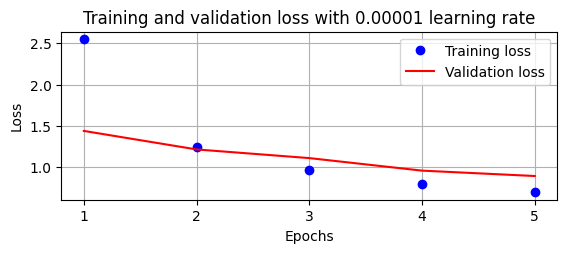

<ipython-input-9-9f61187ce86a>:59: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in


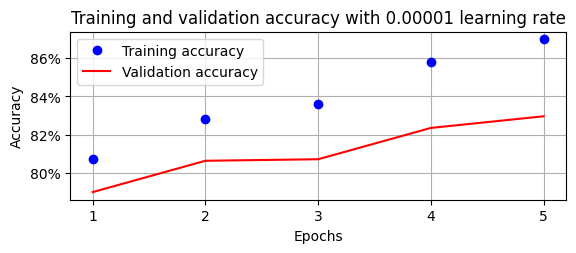

In [9]:
def get_model():
  model = nn.Sequential(
  nn.Linear(28 * 28, 1000),
  nn.ReLU(),
  nn.Linear(1000, 10)
  ).to(device)
  loss_fn = nn.CrossEntropyLoss()
  optimizer = Adam(model.parameters(), lr=1e-5)
  return model, loss_fn, optimizer
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(5):
  print(epoch)
  train_epoch_losses, train_epoch_accuracies = [], []
  for ix, batch in enumerate(iter(trn_dl)):
    x, y = batch
    batch_loss = train_batch(x, y, model, optimizer, loss_fn)
    train_epoch_losses.append(batch_loss)
  train_epoch_loss = np.array(train_epoch_losses).mean()
  for ix, batch in enumerate(iter(trn_dl)):
    x, y = batch
    is_correct = accuracy(x, y, model)
    train_epoch_accuracies.extend(is_correct)
  train_epoch_accuracy = np.mean(train_epoch_accuracies)
  for ix, batch in enumerate(iter(val_dl)):
    x, y = batch
    val_is_correct = accuracy(x, y, model)
    validation_loss = val_loss(x, y, model)
  val_epoch_accuracy = np.mean(val_is_correct)
  train_losses.append(train_epoch_loss)
  train_accuracies.append(train_epoch_accuracy)
  val_losses.append(validation_loss)
  val_accuracies.append(val_epoch_accuracy)

epochs = np.arange(5)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.subplot(211)
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation loss with 0.00001 learning rate')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy with 0.00001 learning rate')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in
plt.gca().get_yticks()])
plt.legend()
plt.grid('off')
plt.show()